# Equation of State
This uses the [equation of state](https://github.com/dionhaefner/pyhpc-benchmarks/blob/master/benchmarks/equation_of_state/eos_jax.py) from the [`pyhpc`](https://github.com/dionhaefner/pyhpc-benchmarks/) benchmark.

In [1]:
import os, copy
#ncpu=1
#os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={ncpu}"
#os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=false " "intra_op_parallelism_threads=1")
#os.environ['JAX_PLATFORMS'] = "cpu"

import numpy as np
import jax
import sys
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax import random

# This must be enabled when `make_jaxpr` is called, because otherwhise we get problems.
jax.config.update("jax_enable_x64", True)


import timeit
from datetime import datetime
from pickle import load


import pyhpc
from pyhpc.equation_of_state import get_callable, generate_inputs
from pyhpc.equation_of_state.eos_jax import gsw_dHdT as CALL
from pyhpc.equation_of_state.eos_numpy import gsw_dHdT as gsw_dHdT_NP

import dace


#### Parameter of Benchmarking

In [2]:
repeat, number = 3000, 50

In [3]:
UseGPU = True

if(UseGPU):
    device = 'GPU'
    ToOpen = "runtime_data/EqOfState_GPU__2023-12-14_11-27-6.pickle"
else:
    device = 'CPU'
    ToOpen = "runtime_data/EqOfState_CPU__2023-12-15_6-31-57.pickle"
#
with open(ToOpen, '+br') as F:
    gSizes, resTime_pf, resTime_jax, resTime_sdfg = load(F)
#

In [4]:
resTime_sdfg_min = np.array([r.min()  for r in resTime_sdfg])
resTime_jax_min = np.array([r.min()  for r in resTime_jax])
resTime_pf_min = np.array([r.min()  for r in resTime_pf])

resTime_sdfg_mean = np.array([r.mean()  for r in resTime_sdfg])
resTime_jax_mean = np.array([r.mean()  for r in resTime_jax])
resTime_pf_mean = np.array([r.mean()  for r in resTime_pf])

resTime_sdfg_std = np.array([r.std()  for r in resTime_sdfg])
resTime_jax_std = np.array([r.std()  for r in resTime_jax])
resTime_pf_std = np.array([r.std()  for r in resTime_pf])

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rcParams["figure.dpi"] = 1000
mpl.rcParams['savefig.bbox'] = 'tight'
#mpl.rcParams['savefig.directory'] = './pic/'
mpl.rcParams['savefig.dpi'] = 'figure'
mpl.rcParams['savefig.edgecolor'] = 'auto'
mpl.rcParams['savefig.facecolor'] = 'auto'
mpl.rcParams['savefig.format'] = 'png'
mpl.rcParams['savefig.orientation'] = 'portrait'
mpl.rcParams['savefig.pad_inches'] = 0.1
mpl.rcParams['savefig.transparent'] = False

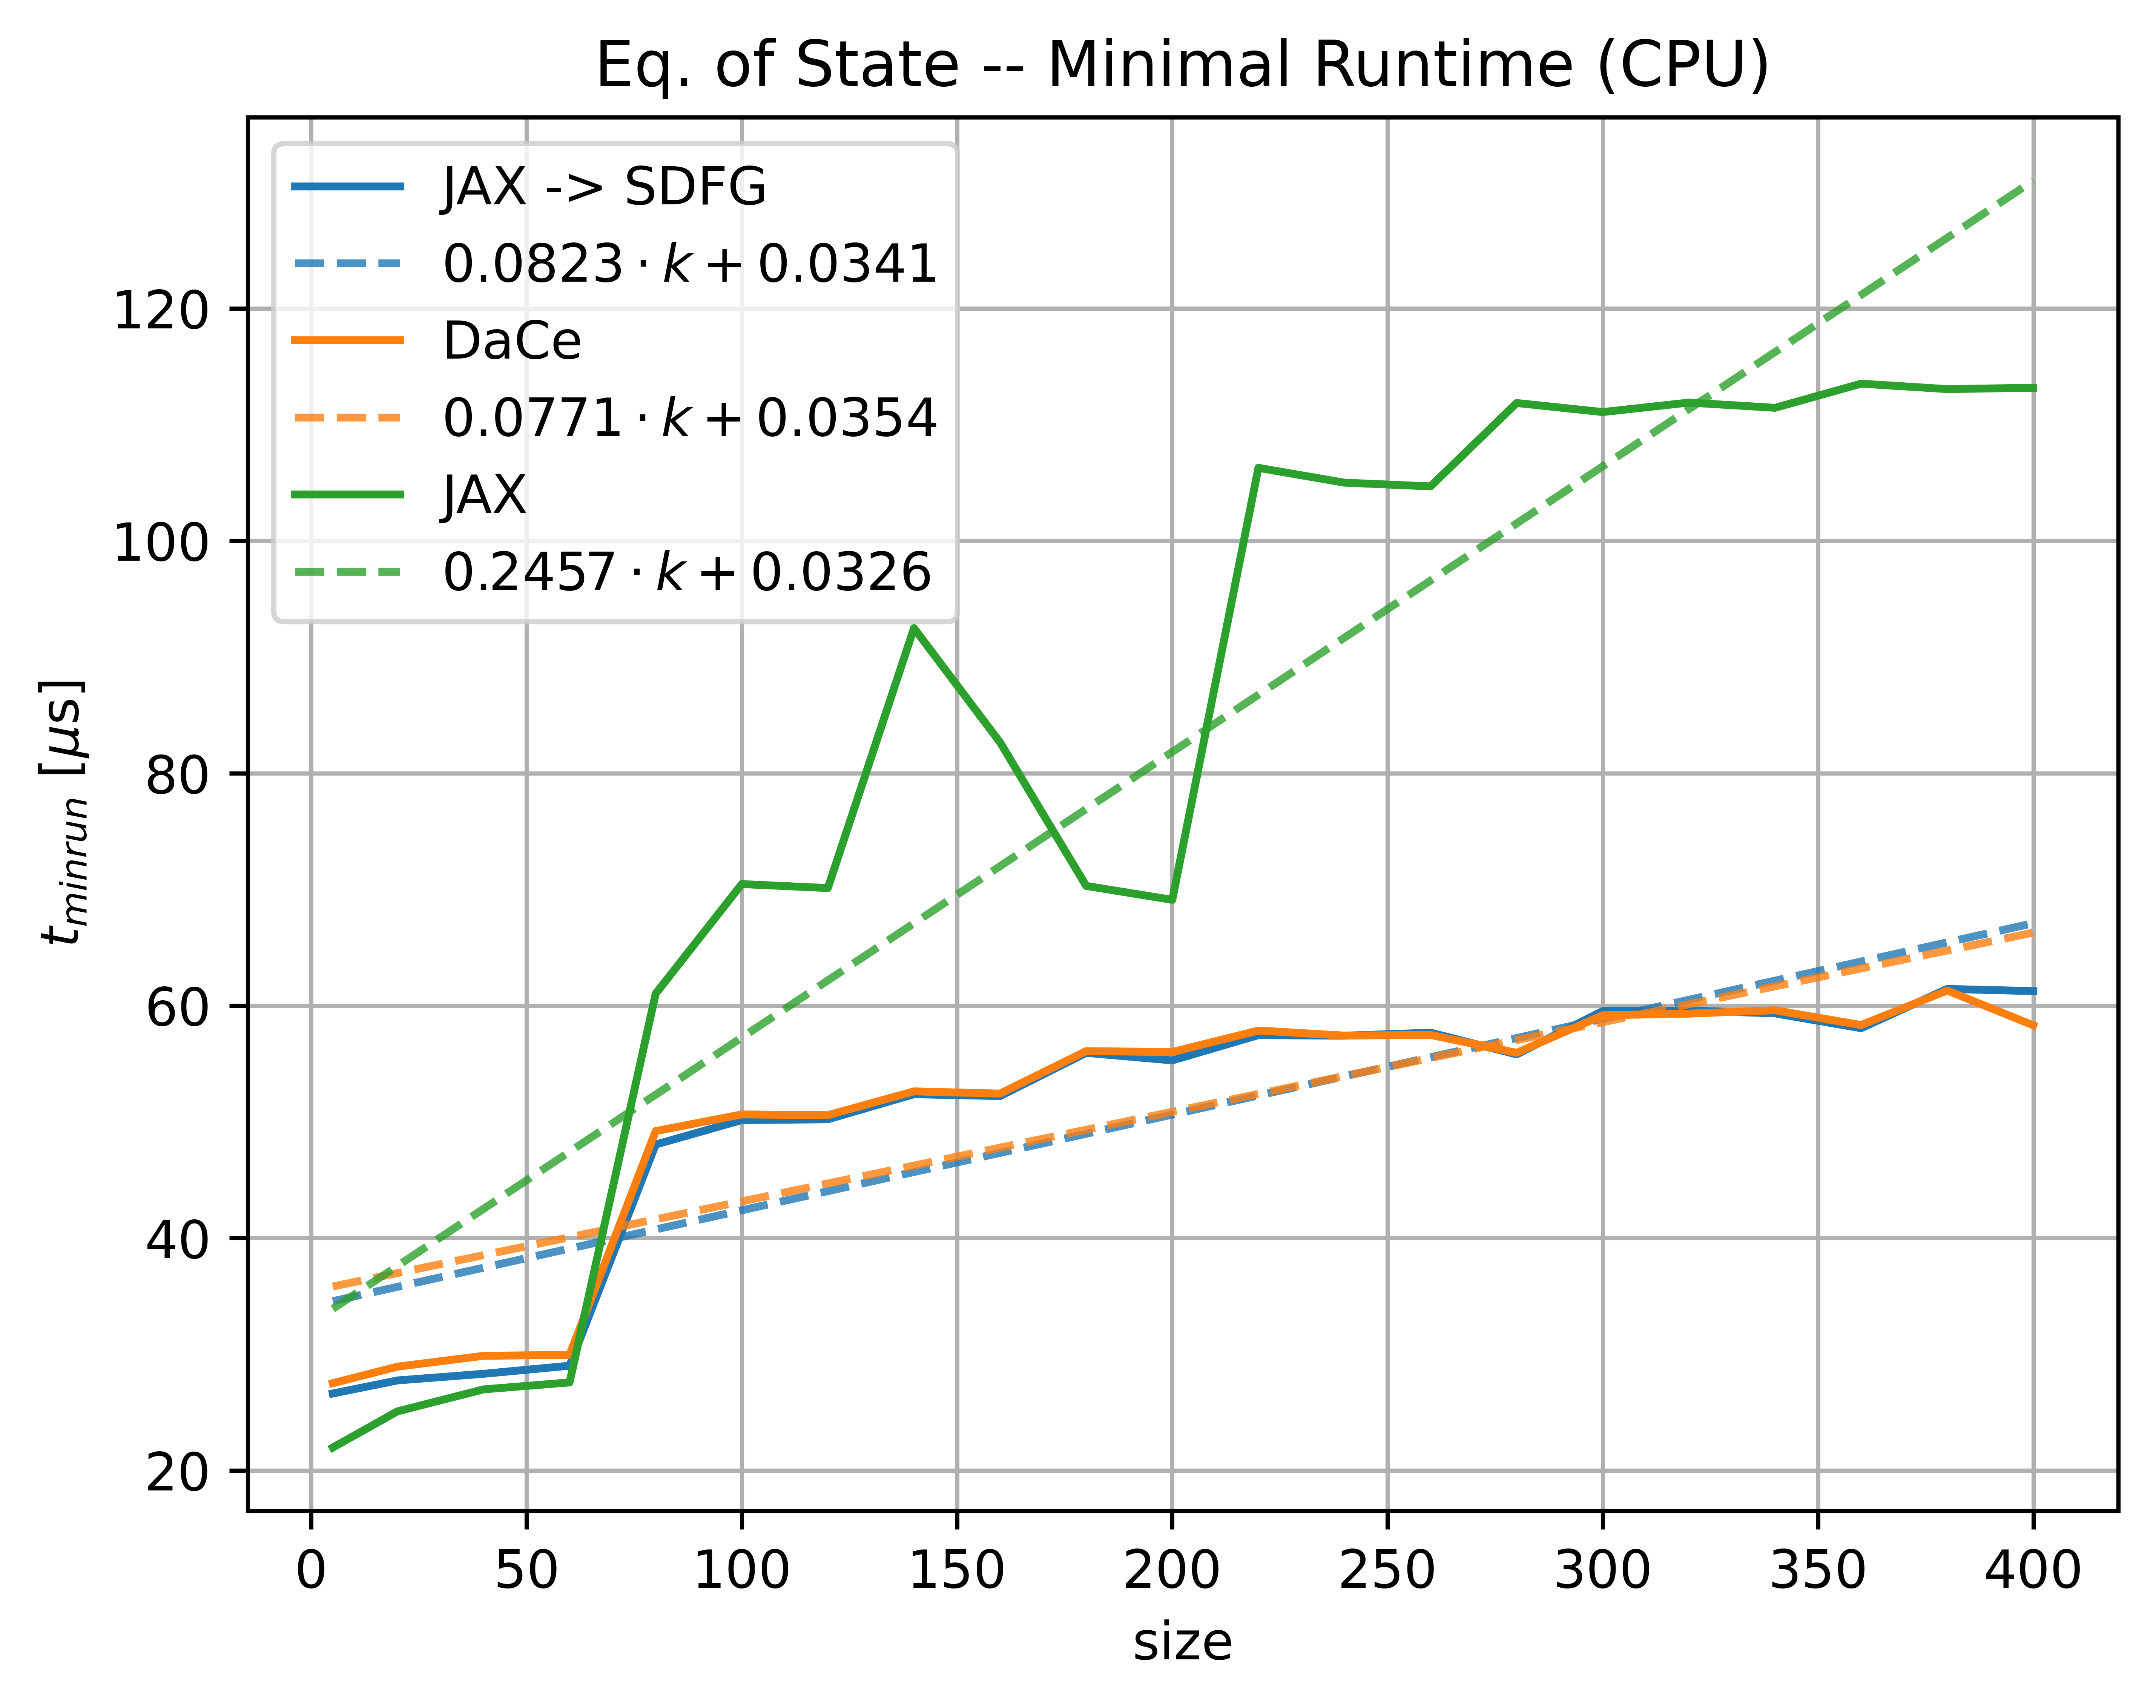

In [6]:
X = np.vstack([gSizes, np.ones_like(gSizes)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'DaCe':         resTime_pf_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(gSizes, Time * 1000000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = np.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * np.array(gSizes) + b
    plt.plot(
        gSizes, Times_ * 1000000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e6*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )
#


plt.legend()
plt.xlabel('size')
plt.ylabel('$t_{min run}$ [$\\mu$s]')
plt.grid(visible=True)
#plt.yscale('log')

plt.title(f"Eq. of State -- Minimal Runtime ({device})")

plt.savefig(f"EoS_{device}_min_runtime.png")

plt.show()


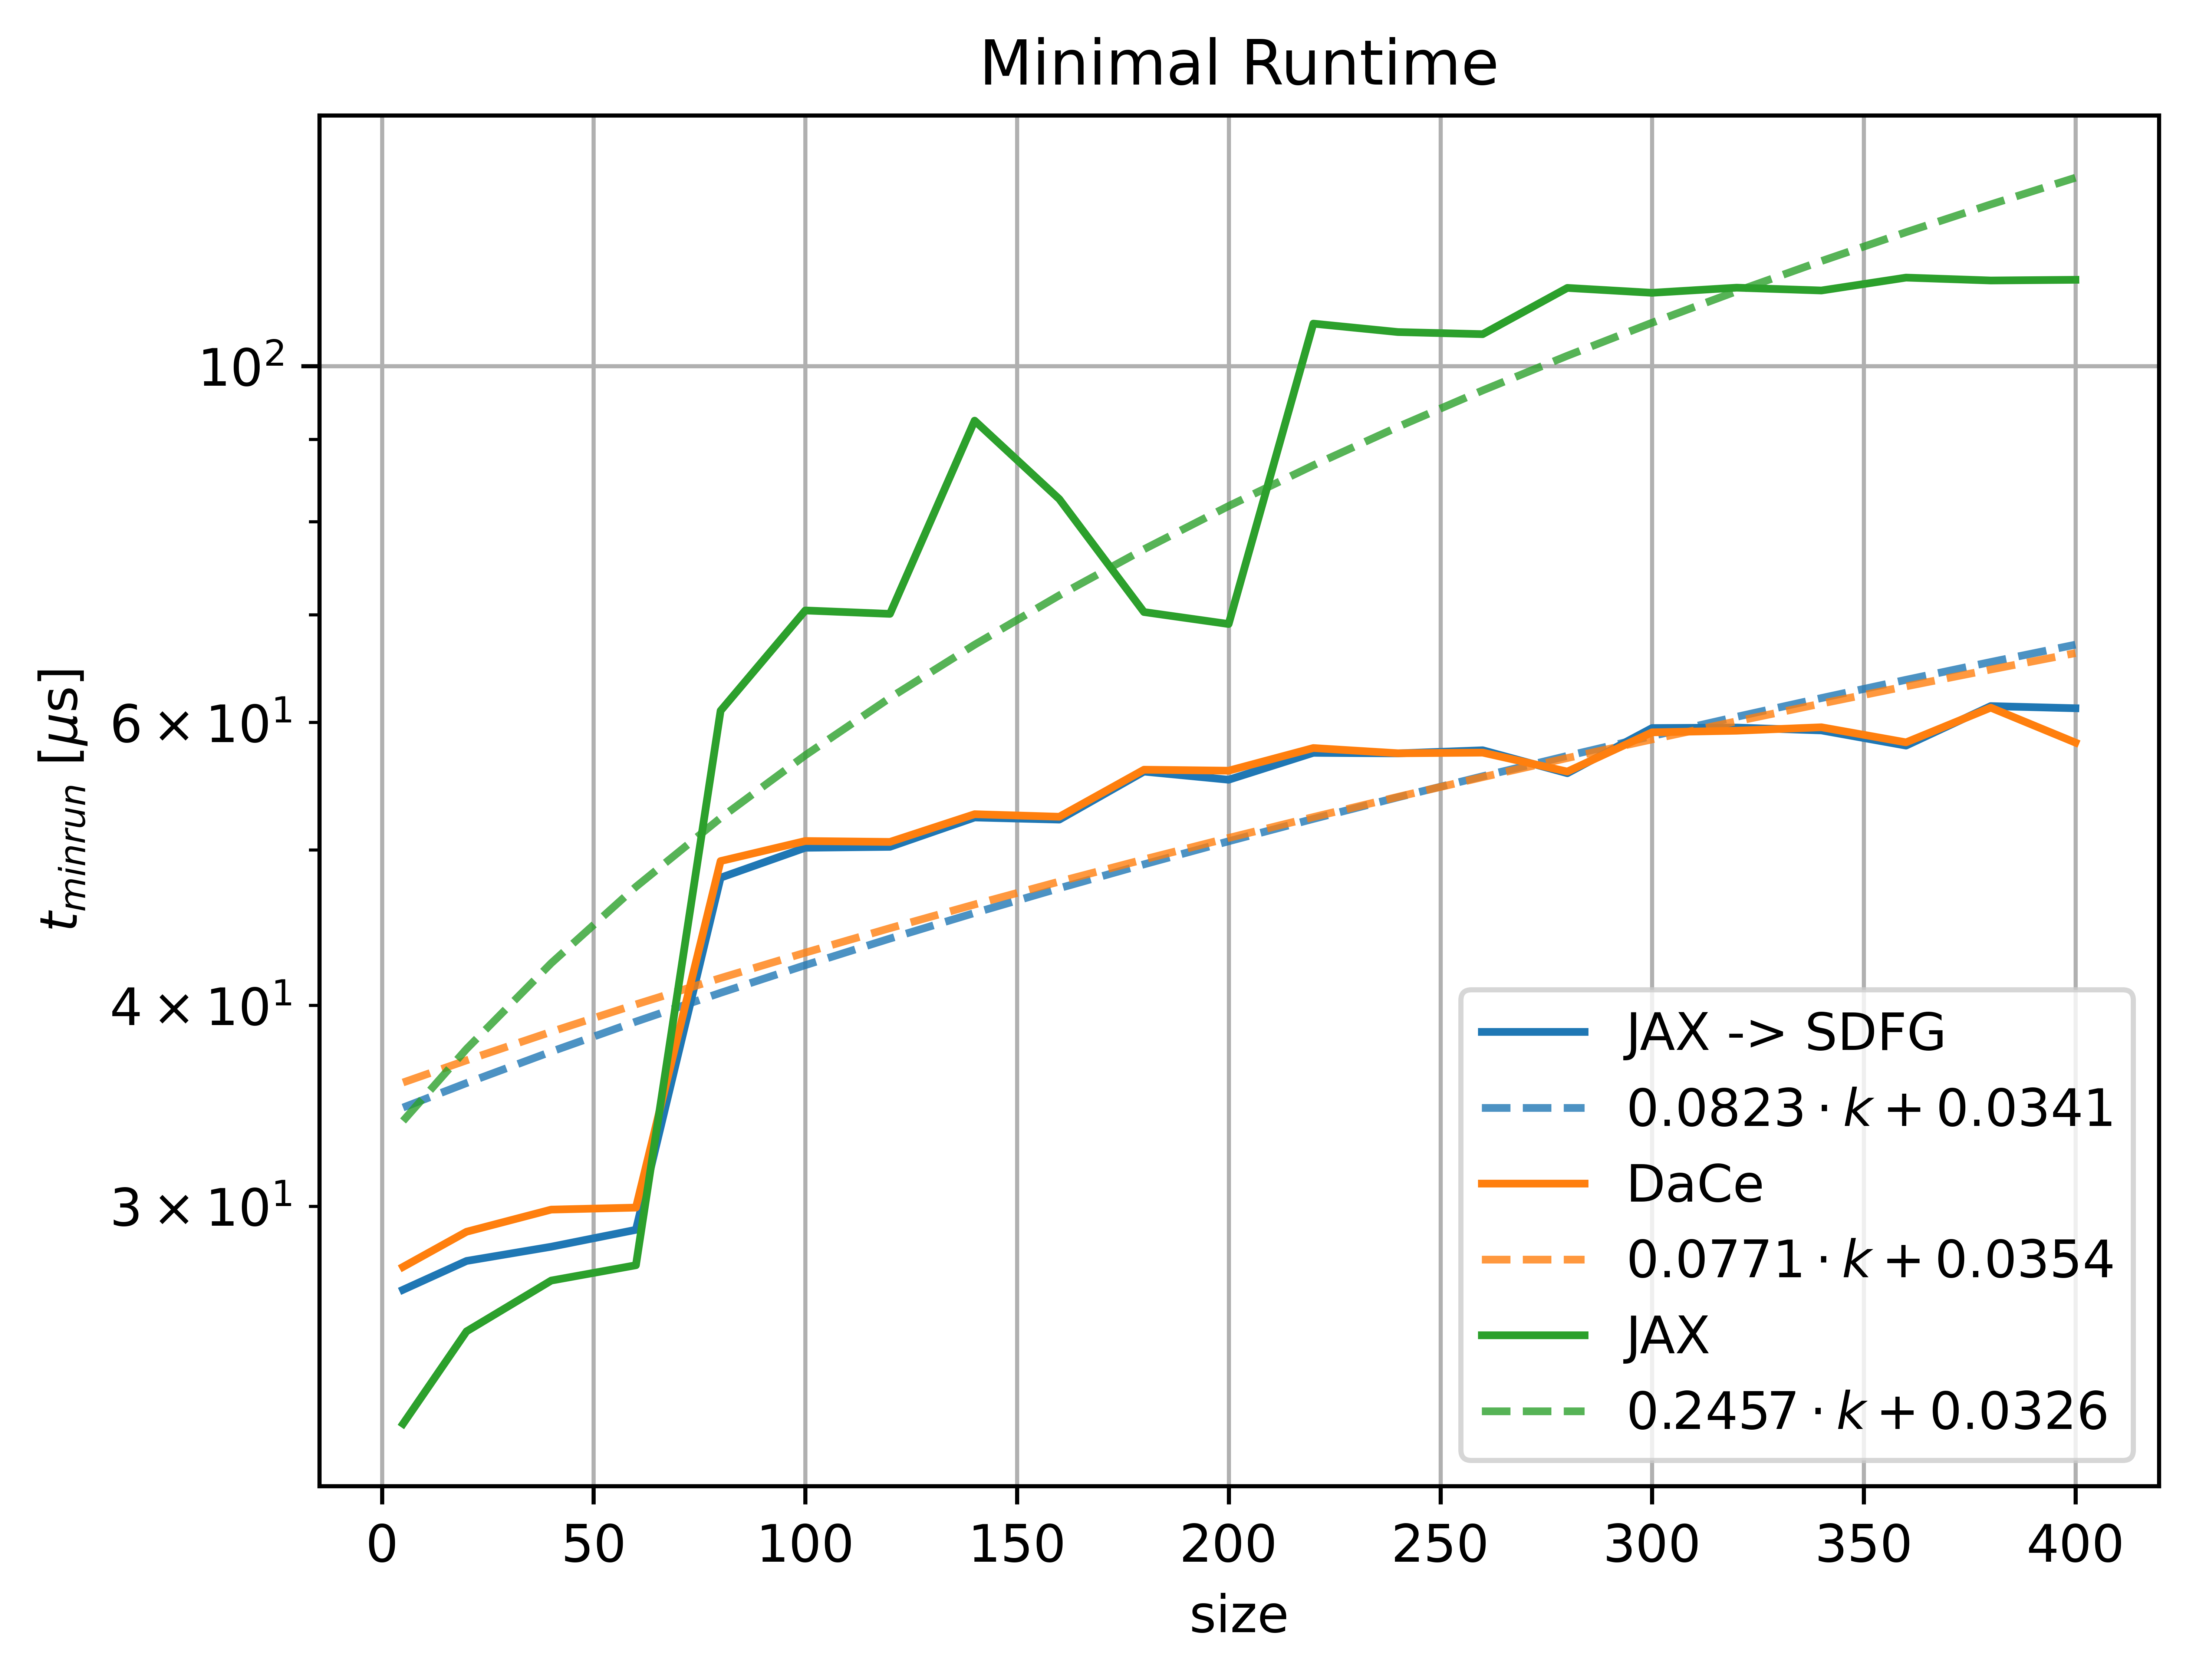

In [7]:
X = np.vstack([gSizes, np.ones_like(gSizes)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'DaCe':         resTime_pf_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(gSizes, Time * 1000000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = np.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * np.array(gSizes) + b
    plt.plot(
        gSizes, Times_ * 1000000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e6*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )
#


plt.legend()
plt.xlabel('size')
plt.ylabel('$t_{min run}$ [$\\mu$s]')
plt.grid(visible=True)
plt.yscale('log')

plt.title("Minimal Runtime")

plt.show()
